<a href="https://colab.research.google.com/github/Ayoubsandali/Deep-Dream-/blob/main/deepdream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1-load image 
2- prepare image 
3-Load the model
4-loss calculation
5-gradiant ascent

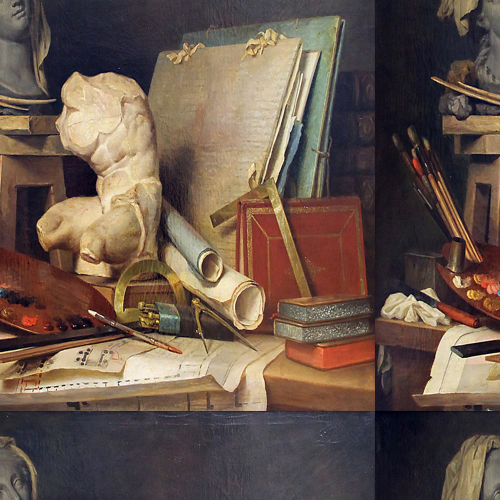

In [188]:
import IPython.display as display
from PIL import Image
import numpy as np
import tensorflow as tf



img_url= "/content/Anne_Vallayer-Coster.jpg"
img=Image.open(img_url).convert('RGB').resize((500,500))
img_to_array = np.array(img).astype('float32')




def normalize(imgarray):
 
    for i in range(0,3):
        min_pixel = imgarray[...,i].min()
        max_pixel = imgarray[...,i].max()
        
        if min_pixel != max_pixel:
            imgarray[...,i]=255*(imgarray[...,i]-min_pixel)/(max_pixel-min_pixel)
               
    return imgarray

def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

shift, img_rolled = random_roll(img_to_array, 512)
display.display(Image.fromarray(img_rolled.numpy().astype('uint8'), 'RGB').convert('RGB'))
    
    


  


In [189]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
names_coeff = {'mixed2': 0.1,'mixed3':0.1,'mixed5':5,'mixed4':4,'mixed6':6}
layers = [base_model.get_layer(name).output for name in list(names_coeff.keys())]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)


In [190]:
def calc_loss(img, model):
  
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        print(act.name)
        act_name=act.name.split('/')[3]
        coeff= tf.constant(names_coeff[act_name],dtype=tf.float32)
        act_weighted = tf.math.multiply(coeff,act)
        loss=tf.reduce_mean(act_weighted)        
        losses.append(loss)

    return  tf.reduce_sum(losses)

In [191]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)
          print(loss)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients

In [192]:
deepdream = DeepDream(dream_model)

In [193]:
def run_deep_dream(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-3,1), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = deepdream(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        print ("Octave {}, Step {}".format(octave, step))

  
  return img

In [194]:
dream_img_array = run_deep_dream(img=img_to_array).numpy()


while/while/model_19/mixed2/concat:0
while/while/model_19/mixed3/concat:0
while/while/model_19/mixed5/concat:0
while/while/model_19/mixed4/concat:0
while/while/model_19/mixed6/concat:0
Tensor("while/while/Sum:0", shape=(), dtype=float32)
Octave -3, Step 0
Octave -3, Step 10
Octave -3, Step 20
Octave -3, Step 30
Octave -3, Step 40
Octave -3, Step 50
Octave -3, Step 60
Octave -3, Step 70
Octave -3, Step 80
Octave -3, Step 90
Octave -2, Step 0
Octave -2, Step 10
Octave -2, Step 20
Octave -2, Step 30
Octave -2, Step 40
Octave -2, Step 50
Octave -2, Step 60
Octave -2, Step 70
Octave -2, Step 80
Octave -2, Step 90
Octave -1, Step 0
Octave -1, Step 10
Octave -1, Step 20
Octave -1, Step 30
Octave -1, Step 40
Octave -1, Step 50
Octave -1, Step 60
Octave -1, Step 70
Octave -1, Step 80
Octave -1, Step 90
Octave 0, Step 0
Octave 0, Step 10
Octave 0, Step 20
Octave 0, Step 30
Octave 0, Step 40
Octave 0, Step 50
Octave 0, Step 60
Octave 0, Step 70
Octave 0, Step 80
Octave 0, Step 90


In [195]:
dream_image=normalize(dream_img_array)


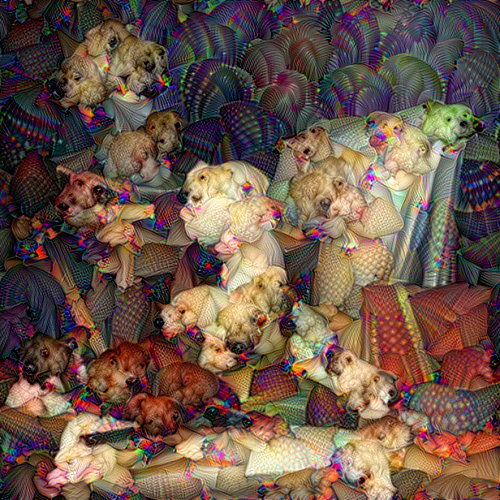

In [196]:
display.display(Image.fromarray(dream_image.astype('uint8')).convert('RGB'))